In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
import dask.array as da
import dask.dataframe as dd
import dask.bag as db
import dask.distributed

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Open BARRA wind netcdf files

In [2]:
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

0.3.0


In [3]:
winds = barra_cairns.wind_dir.compute()
winds_dir = winds[(winds>=0)&(winds<=90)]
wind_times = winds_dir.time.values
def file_paths(variable):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable+"/"
        all_files = [fp+variable+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  
ua850 = file_paths("ua850") 
va850 = file_paths("va850") 
tasmean = file_paths("tas")

In [50]:
def open_and_combine(filepaths,variable_in_fp):
    list = filepaths
    datasets_towns=[]
    datasets_cairns=[]
    datasets_willis=[]
    for fp in list:
        with xr.open_mfdataset(fp, engine="h5netcdf", chunks="auto") as ds:
            towns = ds.sel(lat=-19.4198,method="nearest").sel(lon=slice(143,152))
            cairns = ds.sel(lat=-16.817,method="nearest").sel(lon=slice(143,152))
            willis = ds.sel(lat=-16.2874,method="nearest").sel(lon=slice(143,152))

            # in filepath string variable name is listed- extract to select
            towns = towns[filepaths[0][124:variable_in_fp]] 
            cairns = cairns[filepaths[0][124:variable_in_fp]]
            willis = willis[filepaths[0][124:variable_in_fp]]
            
            datasets_towns.append(towns.groupby(towns.time.dt.hour).mean(dim="time"))
            datasets_cairns.append(cairns.groupby(cairns.time.dt.hour).mean(dim="time"))
            datasets_willis.append(willis.groupby(willis.time.dt.hour).mean(dim="time"))
            ds.close()
    # # calculate wind_speed and wind_dir
    # combine_towns = xr.combine_by_coords(datasets_towns)
    # combine_cairns = xr.combine_by_coords(datasets_cairns)
    # combine_willis = xr.combine_by_coords(datasets_willis)
    return datasets_towns,datasets_cairns,datasets_willis#=[]combine_towns,combine_cairns,combine_willis

In [51]:
tasT,tasC,tasW = open_and_combine(tasmean,127)

In [71]:
tasC

[<xarray.DataArray 'tas' (hour: 24, lon: 82)>
 dask.array<transpose, shape=(24, 82), dtype=float32, chunksize=(24, 82), chunktype=numpy.ndarray>
 Coordinates:
     lat      float64 -16.83
   * lon      (lon) float64 143.0 143.1 143.3 143.4 ... 151.6 151.7 151.8 151.9
   * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
 Attributes:
     long_name:      Near-Surface Air Temperature
     standard_name:  air_temperature
     units:          K
     cell_methods:   time: point (interval: 1H),
 <xarray.DataArray 'tas' (hour: 24, lon: 82)>
 dask.array<transpose, shape=(24, 82), dtype=float32, chunksize=(24, 82), chunktype=numpy.ndarray>
 Coordinates:
     lat      float64 -16.83
   * lon      (lon) float64 143.0 143.1 143.3 143.4 ... 151.6 151.7 151.8 151.9
   * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
 Attributes:
     long_name:      Near-Surface Air Temperature
     standard_name:  air_temperature
     units:          K
     ce

In [69]:
tasCC = xr.concat(tasC,'hour')

In [75]:
# tasCC=tasCC.drop_vars("lat")
tasCC

1008

TypeError: Input z must be 2D, not 1D

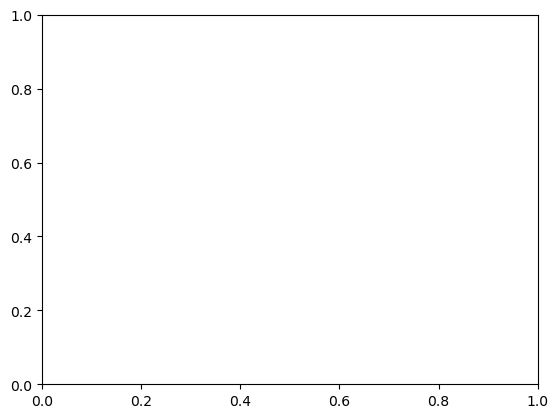

In [45]:
plt.contourf(tasCC.lon,tasCC.hour,tasCC)

# Read in through dask radar datasets

In [23]:
%%time
# use barra wind directions to look into "direction" periods raining 
winds = barra_cairns.wind_dir.compute()
winds_dir = winds[(winds>270)&(winds<=360)]
wind_times = winds_dir.time.values

CPU times: user 19.5 ms, sys: 1.29 ms, total: 20.8 ms
Wall time: 19.5 ms


In [2]:
def path_to_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

cairns_radar_files = path_to_radar_ds("19")
willis_radar_files = path_to_radar_ds("41")

In [25]:
def read_netcdf(file_path,wind_times,cairns=None,bb=None):
    with xr.open_mfdataset(file_path) as ds:
        # Perform any processing on the dataset
        barra_winds = ds.rainrate.sel(time=wind_times,method='nearest')

        if cairns==True:
            polygon = Polygon([
                (-150000, 20000),
                (-150000, -20000),
                (150000, -20000),
                (150000, 20000),
            ])
        else:
            polygon = Polygon([
                        (-150000, -39000),
                        (-150000, -79000),
                        (150000, -79000),
                        (150000, -39000),
                    ])
        gdf = gpd.GeoDataFrame({'geometry': [polygon]})
        # for cairns
        mask = regionmask.mask_geopandas(gdf, ds.x, ds.y,wrap_lon=False) 
        masked_ds = barra_winds.where(~mask.isnull()) #ds.rainrate.where(~mask.isnull()) 
        mean_rr = masked_ds.mean(dim='time')
        if bb==True:
            masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
            mask_ds = barra_winds.where(~masked_beam_blockage.isnull()) #ds.rainrate.where(~masked_beam_blockage.isnull()) 
        else:
            mask_ds = barra_winds.where(~mean_rr.isnull()) #ds.rainrate.where(~mean_rr.isnull()) 
        
        # For example, compute mean of a variable
        result = mask_ds.fillna(0) #mask_ds, fill nans (times with no rain) as zeros
    return result

In [26]:
%%time
cairns_data = read_netcdf(cairns_radar_files,wind_times,cairns=True,bb=False) # stopping the data being removed by bb

CPU times: user 14.5 s, sys: 1.39 s, total: 15.9 s
Wall time: 17.1 s


In [27]:
willis_data = read_netcdf(willis_radar_files,cairns=False,bb=False)

In [28]:
rr_cairns = cairns_data.groupby(cairns_data.time.dt.hour).mean(dim=["y","time"])

In [29]:
rr_willis = willis_data.groupby(willis_data.time.dt.hour).mean(dim=["y","time"])

In [30]:
%%time
result = rr_cairns.compute()

CPU times: user 1min 34s, sys: 3.94 s, total: 1min 38s
Wall time: 1min 21s


In [31]:
%%time
resultW = rr_willis.compute()

CPU times: user 1min 7s, sys: 3.04 s, total: 1min 10s
Wall time: 57.4 s


In [32]:
cairns_long = xr.open_dataset('/g/data/rq0/level_2/19/RAINRATE/19_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
cairns_lon = cairns_long.longitude.isel(y=150).values
willis_long = xr.open_dataset('/g/data/rq0/level_2/41/RAINRATE/41_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
willis_lon = willis_long.longitude.isel(y=150).values
# cairns_lon[:-6]
cairns_latt = xr.open_dataset('/g/data/rq0/level_2/19/RAINRATE/19_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
cairns_lat = cairns_latt.latitude.isel(x=150).values
willis_latt = xr.open_dataset('/g/data/rq0/level_2/41/RAINRATE/41_20120101_rainrate.nc', engine="h5netcdf", chunks="auto") 
willis_lat = willis_latt.latitude.isel(x=150).values

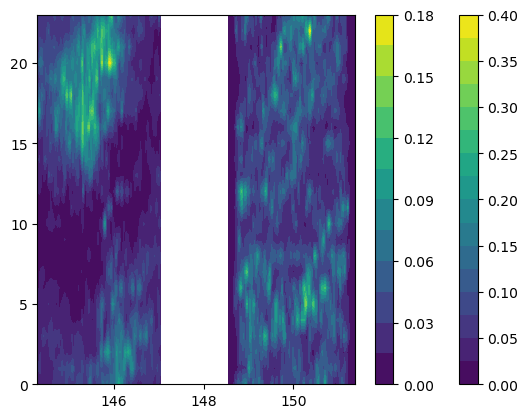

In [33]:
cairns_aest = np.roll(result,shift=10,axis=0)
willis_aest = np.roll(resultW,shift=10,axis=0)

cf1=plt.contourf(cairns_lon[3:-6],np.arange(0,24,1),cairns_aest[:, 3:-6],levels=15)
plt.colorbar(cf1)
cf2=plt.contourf(willis_lon,np.arange(0,24,1),willis_aest,levels=15)
plt.colorbar(cf2)


# transect plot

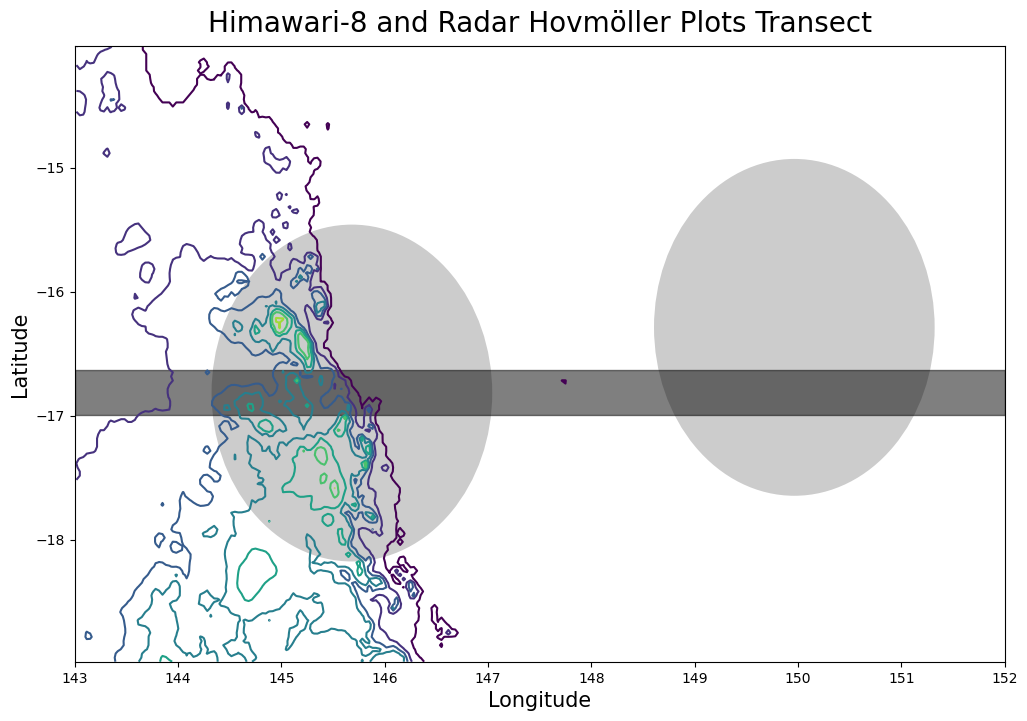

In [14]:
# plot horizontal transect
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(143,152),y=slice(-19,-14))#.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)

fig, ax = plt.subplots(1,1,figsize=(12,8))
fig.patch.set_facecolor('white')
# changing between mask and masked_ds (bb with or without)
import matplotlib.patches as mpatches
circle_C = mpatches.Circle((145.683,-16.817),1.358,alpha=0.4,fc="grey") # Cairns
circle_W = mpatches.Circle((149.9646,-16.2874),1.358,alpha=0.4,fc="grey") # Willis Island
ax.add_patch(circle_C) 
ax.add_patch(circle_W)
polygon_C = mpatches.Polygon([(144.27374, -16.633728), (147.09222, -16.633728), (147.09222, -16.993225),(144.27374,-16.993225)], edgecolor='black')
polygon_W = mpatches.Polygon([(148.55927, -16.633728), ( 151.36993, -16.633728), ( 151.36993, -16.993225),(148.55927,-16.993225)], edgecolor='black', facecolor='none')
polygon_all = mpatches.Polygon([(143, -16.633728), (152, -16.633728), (152, -16.993225),(143,-16.993225)], edgecolor='black',facecolor="black",alpha=0.5)

# ax.add_patch(polygon_C)
# ax.add_patch(polygon_W)
ax.add_patch(polygon_all)
# ax.contourf(cairns_lon, cairns_lat, cairns_long.rainrate.mean(dim=['time']),levels=0,colors='grey',alpha=1)
# ax.contourf(willis_lon, willis_lat, willis_long.rainrate.mean(dim=['time']),levels=0,colors='grey',alpha=1)
# ax.contourf(cairns_lon, cairns_lat, cairns_plot,levels=1,colors="black",alpha=1)
# ax.contourf(willis_lon, willis_lat, willis_plot,levels=1,colors="black",alpha=1)

sel_lat_lon = ds_bath["z"]#.sel(x=slice(140,155),y=slice(-22,-11)) #(x=slice(144.3,147.2),y=slice(-18.5,-15.2) #towns:x=slice(145,148.2),y=slice(-21,-17.8)
cmapc = plt.get_cmap('viridis')
ax.contour(lon, lat,sel_lat_lon,levels=np.arange(0,1600,200),cmap=cmapc,alpha=1)
ax.set_ylabel("Latitude",fontsize=15)
ax.set_xlabel("Longitude",fontsize=15)
ax.set_xticks(np.arange(143,153,1))
ax.set_xlim(143,152)
ax.set_title("Himawari-8 and Radar Hovmöller Plots Transect",fontsize=20,pad=10);

# not using dask

In [15]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="h5netcdf", chunks="auto") #={'time':-1})

In [16]:
%%time
# open radar ds
# ds_radar_T = open_radar_ds("73")
ds_radar_C = open_radar_ds("19")
ds_radar_W = open_radar_ds("41")

CPU times: user 2min 15s, sys: 1.04 s, total: 2min 16s
Wall time: 2min 17s


In [ ]:
%%time
# ds_radar_T = ds_radar_T.persist()
ds_radar_C = ds_radar_C.persist()
ds_radar_W = ds_radar_W.persist()

In [ ]:
# polygon for cairns - horizontal to also intersect the willis island radar site
polygon = Polygon([
            (-150000, 20000),
            (-150000, -20000),
            (150000, -20000),
            (150000, 20000),
        ])
polygonW = Polygon([
            (-150000, -35000),
            (-150000, -75000),
            (150000, -75000),
            (150000, -35000),
        ])
gdf = gpd.GeoDataFrame({'geometry': [polygon]})
gdfW = gpd.GeoDataFrame({'geometry': [polygonW]})
# for cairns
mask = regionmask.mask_geopandas(gdf, ds_radar_C.x, ds_radar_C.y,wrap_lon=False) 
maskW = regionmask.mask_geopandas(gdfW, ds_radar_W.x, ds_radar_W.y,wrap_lon=False) 

masked_ds = ds_radar_C.rainrate.where(~mask.isnull()) 
masked_dsW = ds_radar_W.rainrate.where(~maskW.isnull()) 

mean_rr = masked_ds.mean(dim='time')
mean_rrW = masked_dsW.mean(dim='time')

masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
mask_ds = ds_radar_C.rainrate.where(~masked_beam_blockage.isnull()) # change for C or T

mask_dsW = ds_radar_W.rainrate.where(~mean_rrW.isnull()) 

In [ ]:
# plot horizontal transect
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)
dem = ds_bath['z'].data

fig, ax = plt.subplots(1,1,figsize=(14,6))
fig.patch.set_facecolor('white')
# changing between mask and masked_ds (bb with or without)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), masked_ds.mean(dim='time'),levels=1,colors="magenta",alpha=1)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), mask_ds.mean(dim='time'),levels=1,colors="black",alpha=1)
ax.contourf(ds_radar_W.longitude.isel(time=0), ds_radar_W.latitude.isel(time=0), mask_dsW.mean(dim='time'),levels=1,colors="black",alpha=1)

ax.contourf(ds_radar_W.longitude.isel(time=0), ds_radar_W.latitude.isel(time=0), ds_radar_W.rainrate.mean(dim=['time']),levels=1,colors='grey',alpha=0.3)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), ds_radar_C.rainrate.mean(dim=['time']),levels=1,colors='grey',alpha=0.3)
# ax.contour(lon,lat,dem,levels=10,extend="both",cmap='binary')
sel_lat_lon = ds_bath["z"].sel(x=slice(140,155),y=slice(-18.20,-15)) #(x=slice(144.3,147.2),y=slice(-18.5,-15.2) #towns:x=slice(145,148.2),y=slice(-21,-17.8)
cmapc = plt.get_cmap('viridis')
sel_lat_lon.plot.contour(levels=10,ax=ax, cmap=cmapc,alpha=1,vmin=0)

ax.set_ylabel("Latitude",fontsize=12)
ax.set_xlabel("Longitude",fontsize=12)
ax.set_title("Hovmöller Transect",fontsize=15,pad=10)

In [ ]:
# using the above radar masks, groupby hour

rr_cairnsmask_grp = mask_ds.groupby(mask_ds.time.dt.hour)
rr_willismask_grp = mask_dsW.groupby(mask_dsW.time.dt.hour)
cairns_rry_utc = []
willis_rry_utc = []
for hours in np.arange(0,24,1):
    rr_cairns = rr_cairnsmask_grp[hours].mean(dim=["y","time"])
    rr_willis = rr_willismask_grp[hours].mean(dim=["y","time"])
    cairns_rry_utc.append(rr_cairns.values)
    willis_rry_utc.append(rr_willis.values)
    print(hours)

In [ ]:
# convert to aest (y)
cairns_rry_aest = np.roll(cairns_rry_utc,shift=10,axis=0)
willis_rry_aest = np.roll(willis_rry_utc,shift=10,axis=0)
cf1=plt.contourf(np.arange(0,295,1),np.arange(0,24,1),cairns_rry_aest[:, :-6],levels=15)
plt.colorbar(cf1)
# cf2=plt.contourf(np.arange(0,301,1),np.arange(0,24,1),willis_rry_aest,levels=15)
# plt.colorbar(cf2)


# get satellite data

In [2]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/himawari_regridded_files"
files = him8_files(directory)

In [ ]:
ds_barra = xr.open_mfdataset('/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc',engine="netcdf4")
ds_barra['time'] = pd.to_datetime(ds_barra['time'])
ds_barra = ds_barra.sortby('time')
ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
winds = barra.wind_dir.compute()
winds_dir = winds[(winds>270)&(winds<=360)]
wind_times = winds_dir.time.values

In [ ]:
def read_netcdf_him8(file_path):
    with xr.open_mfdataset(file_path) as ds:
        barra_winds = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-16.993225,-16.633728)) 
        # data = ds.ch13BT.sel(lat=slice(-17.3,-16.3)) #-16.817,method="nearest"
        result_mean = barra_winds.groupby(barra_winds.time.dt.hour).mean(dim=["lat","time"])  # barra_winds need to be put in twice here
        result_median = barra_winds.groupby(barra_winds.time.dt.hour).median(dim=["lat","time"])
    return result_mean,result_median 

In [35]:
%%time
ds_him_mean,ds_him_med = read_netcdf_him8(files)

CPU times: user 514 ms, sys: 116 ms, total: 630 ms
Wall time: 656 ms


In [36]:
%%time
result_mean = ds_him_mean.compute()

CPU times: user 11.2 s, sys: 1.39 s, total: 12.6 s
Wall time: 21.3 s


In [37]:
%%time
result_med = ds_him_med.compute()

CPU times: user 10.3 s, sys: 611 ms, total: 10.9 s
Wall time: 8.47 s


In [38]:
bt_mean_aest = np.roll(result_mean,shift=10,axis=0)
bt_med_aest = np.roll(result_med,shift=10,axis=0)

In [39]:
bt_long = xr.open_dataset('/home/563/ac9768/2020_ch13BT_regridded_2kmres.nc', engine="h5netcdf", chunks="auto")
bt_lon = bt_long.lon.values

# Plot satellite and radar

In [40]:
# double all arrays to plot between 48 hours
double_him_mean = np.concatenate([bt_mean_aest,bt_mean_aest])
double_him_med = np.concatenate([bt_med_aest,bt_med_aest])
double_cairns = np.concatenate([cairns_aest[:, 6:-6],cairns_aest[:, 6:-6]]) 
double_willis = np.concatenate([willis_aest[:, 17:-17],willis_aest[:, 17:-17]]) 

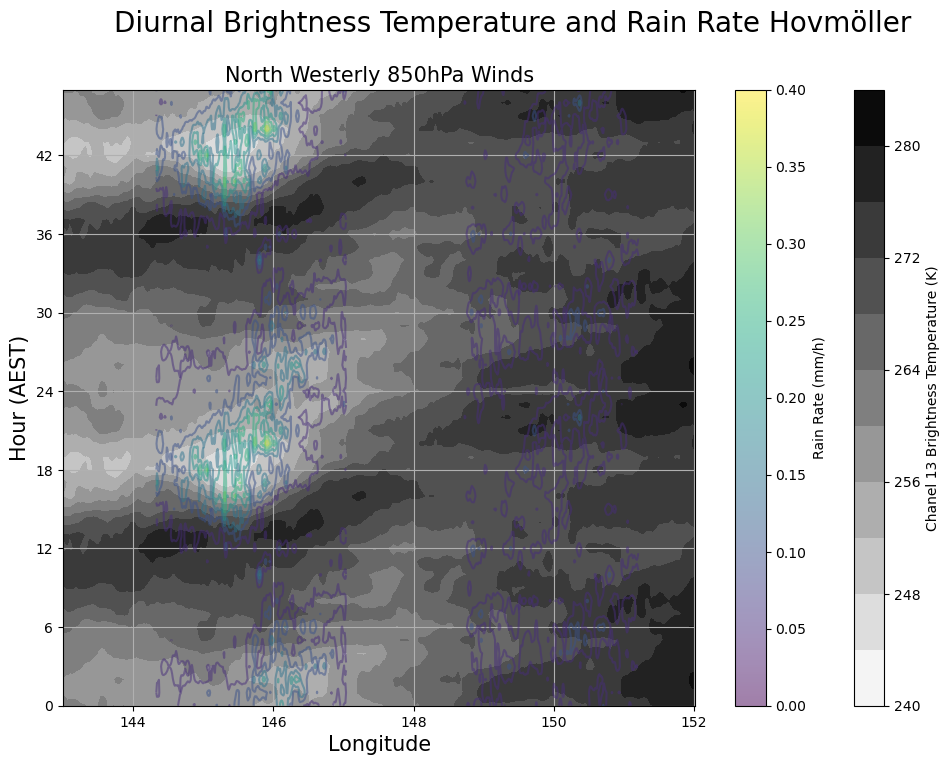

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
fig.patch.set_facecolor('white')
level=np.arange(265,290,0.75)
level=np.arange(264,290,0.75)
cf0=plt.contourf(bt_lon,np.arange(0,48,1),double_him_mean,levels=10,cmap="binary",alpha=1)
plt.colorbar(cf0,label="Chanel 13 Brightness Temperature (K)",pad=0.000005)
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)
sm = sm.set_array(np.arange(0,6,1))
levels=np.arange(0,0.45,0.05)
cf1=plt.contour(cairns_lon[6:-6],np.arange(0,48,1),double_cairns,levels=levels,cmap="viridis",alpha=0.5)
# cb=plt.colorbar(cf1,label="Rain Rate (mm/h)",ticks=levels,pad=0.05)
norm= matplotlib.colors.Normalize(vmin=cf1.cvalues.min(), vmax=cf1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cf1.cmap)
sm.set_array([])
plt.colorbar(sm,label="Rain Rate (mm/h)",ticks=cf1.levels,ax=ax,alpha=0.5)

cf2=plt.contour(willis_lon[17:-17],np.arange(0,48,1),double_willis,levels=levels,alpha=0.5,cmap="viridis")
ax.set_xlabel("Longitude",fontsize=15)
ax.set_ylabel("Hour (AEST)",fontsize=15)
ax.set_yticks(np.arange(0,48,6))
ax.grid()
fig.suptitle("Diurnal Brightness Temperature and Rain Rate Hovmöller",fontsize=20);
ax.set_title("North Westerly 850hPa Winds",fontsize=15); #Mean for latitudes shared by Cairns and Willis Island radar sites